In [1]:
import torch
torch.set_grad_enabled(False)
import sys
import time
import random
import csv
import numpy as np
import threading 
import scipy.io
from scipy.io import loadmat

import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

import copy
# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_dtype(TORCH_DTYPE)
torch.set_default_device(device)
print(f'Device is: {device}')


# BUG:
# cell 2 with initialization of receptive giels as in melide gives -inv lambda0




Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


### What is this:

We choose initial training points to be considered a random set of images to present to the retina. 

We fit a complete GP with ntilde=ntrain on those. This will be our starting fit / our starting model

From the starting fit, we start two different closed loop fits.

##### Active loop

We add the most useful images one at the time, each time recomputing the fit, until we reach the maximum amount of images that we want to show.

At each model fit we estimate the loglikelihood predicted on a test set. This us fixed in this notebook, like the starting ntrain is.

##### Random loop

We add a random image one ad the time and compute the fit, also estimating the predicted likelihood each time.

Differently than the active loop, we do so many times (~10) to obtain an everage trend of how fast the model is learning. 

This trend was fixed for the active loop once the starting inducing points have been fixed, that's why we only did one repetition

##### Steps

1. Import the dataset and create a total training set X,R
2. Pick the cell and the initial training points, extracted randomly. These correspond also to the number of inducing points
3. Estimate the utility of each image that was not used to train
4. Add that image to the training set for the nxt iteration


We decomposed these first steps in different cells, wich are all composed together at the end



### Parameters of the training

In [2]:
cellid       = 35        # Choose the cell 
ntrain_start = 50        # Number of first training data points

kernfun      = 'acosker' # Choose kernel function

nEstep       = 10         # Total number of E-steps iterations.
nFparamstep  = 10  
nMstep       = 10         # Total number of M-steps iterations. 
maxiter      = 10         # Iterations of the optimization algorithm comprising M and E steps

ntilde       = ntrain_start
n_test_lk    = 1000       # Number of test data points on which to compute log-likelihood, to compare 2 models without using the r2 score

# n_add_images = 3160 - n_test_lk - ntrain_start    
n_add_images = 300
n_random_starts = 10  

### Import dataset and generate starting dataset

Create starting dataset on which to train with m step with ntilde = ntrain_start

In [3]:
# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) # shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE)  # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) # shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE)  # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/Gaussian-Processes/Spatial_GP_repo/raw_electrode_and_sorted_datasets/electrode_51_set_train_R_raw.npy', 'rb') as file:
#     # Load the data from the file
#     loaded_data_raw = np.load(file)
# R_raw = torch.tensor(loaded_data_raw).to(device, dtype=TORCH_DTYPE) 

# with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/Gaussian-Processes/Spatial_GP_repo/raw_electrode_and_sorted_datasets/cluster_cell_962_matlab_cell_159_python_cell_35_set_train_R_sorted.npy', 'rb') as file:
#     loaded_data_original = np.load(file)

# R_original = loaded_data_original

# Create the complete dataset
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)

n_px_side = X.shape[1]  

# Reshape images to 1D vector and choose a cell
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
R = R[:,cellid] # shape (nt,) where nt is the number of trials
R_test = R_test[:, :, cellid] # shape (30,30) where 30 is the number of repetitions

# BUG CHECK:
# When the random loop reaces an ntilde == 0.5*ntrain_start the code breaks, lets try reducing ntrain_start
# To reproduce the bug with ntilde 1080 upload 'cell:14_negative_variance'

# X = X[:1000,:]
# R = R[:1000]

# n_test_lk    = 500       # Number of test data points on which to compute log-likelihood, to compare 2 models without using the r2 score

# n_add_images = 450    
# n_random_starts = 10  

###################################################

# Choose a random subset of the data and save the idx
all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
torch.manual_seed(0)
torch.cuda.manual_seed(0)
all_idx_perm  = torch.randperm(all_idx.shape[0])                         # Random permutation of the indices

test_1000_idx = all_idx_perm[-n_test_lk:]                                # Take the last 1000 images out of the set
all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] # Remove the test set indices from the permutation
rndm_idx      = all_idx_perm[:ntrain_start]                              # These will be the indices of the initial training. This way ensures not repetitions.

start_idx     = rndm_idx
in_use_idx    = start_idx
xtilde_idx    = in_use_idx
remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]
# remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

# Set the starting set
xtilde_start  = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
X_in_use      = X[in_use_idx,:]
X_remaining   = X[remaining_idx,:]
X_test_1000   = X[test_1000_idx,:]

R_remaining   = R[remaining_idx]
R_in_use      = R[in_use_idx]
R_test_1000   = R[test_1000_idx]

# Estimate memory usage
# Calculate memory usage for each tensor
X_memory = X.element_size() * X.nelement()
r_memory = R.element_size() * R.nelement()
# Total memory usage in bytes
total_memory_bytes = X_memory + r_memory
# Convert bytes to megabytes (MB)
total_memory_MB = total_memory_bytes / (1024 ** 2)
print(f'Total dataset memory on GPU: {total_memory_MB:.2f} MB')


Total dataset memory on GPU: 281.23 MB


### Select cell, starting hyperparameters and firing rate parameters

In [4]:
torch.set_grad_enabled(False)

# These are the hyperparametrs used as initial condition when there is an M step ( hyperparameter learning)

# For details on the hyperparameters choice see one_cell_fit.ipynb
logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 
sigma_0    = torch.tensor(1.0)
Amp        = torch.tensor(1.0) 
eps_0x     = torch.tensor(0.0001)
eps_0y     = torch.tensor(0.0001)
eps_0x     = torch.tensor(-0.15878)
eps_0y     = torch.tensor(-0.08321)
theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

# Set the gradient of the hyperparemters to be updatable 
for key, value in theta.items(): # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0 and dont do the M-step)
    # if key == 'Amp':
        # continue
    theta[key] = value.requires_grad_()

# If hyperparameters are set manually:
# theta = prev_theta
hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
# If hyperparameters are set based on the STAs:
# hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

A        = torch.tensor(0.01)
logA     = torch.log(A)
# lambda0  = torch.tensor(0.31)
lambda0  = torch.tensor(1.)
f_params = {'logA': logA, 'lambda0':lambda0}
f_params['logA'] = f_params['logA'].requires_grad_() # The optimal lambda0 is given with a fixed A.

fit_parameters = {'ntilde':      ntilde,
                  'maxiter':     maxiter,
                  'nMstep':      nMstep,
                  'nEstep':      nEstep,
                  'nFparamstep': nFparamstep,
                  'kernfun':     kernfun,
                  'cellid':      cellid,
                  'n_px_side':   n_px_side,
                  'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                  'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                  'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

init_model = {
        'fit_parameters':    fit_parameters,
        'xtilde':            xtilde_start,
        'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
        'f_params':          f_params,
    }

updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to -0.1588
updated eps_0y to -0.0832
updated -2log2beta to 4.8069
updated -log2rho2 to 4.3069


### Fit the starting model
And save it needed to start a new active fit

Initial Loss: 147.1126
Loss iter 1: 45.6258
Loss iter 2: 45.6255
Loss iter 3: 45.6254
Loss iter 4: 45.6254
Loss iter 5: 45.6254
Loss iter 6: 45.6254
Loss iter 7: 45.6254
Loss iter 8: 45.6254
Loss iter 9: 45.6254

Time spent for E-steps:       0.437s,
Time spent for f params:      0.243s
Time spent for m update:      0.195s
Time spent for M-steps:       0.123s
Time spent for All-steps:     0.560s
Time spent computing Kernels: 0.018s
Time spent computing Loss:    0.004s

Time total after init:        0.589s
Time total before init:       0.642s
Final Loss: 45.6254


 Pietro's model: R2 = 0.03 ± 0.01 Cell: 35 maxiter = 10, nEstep = 10, nMstep = 10 



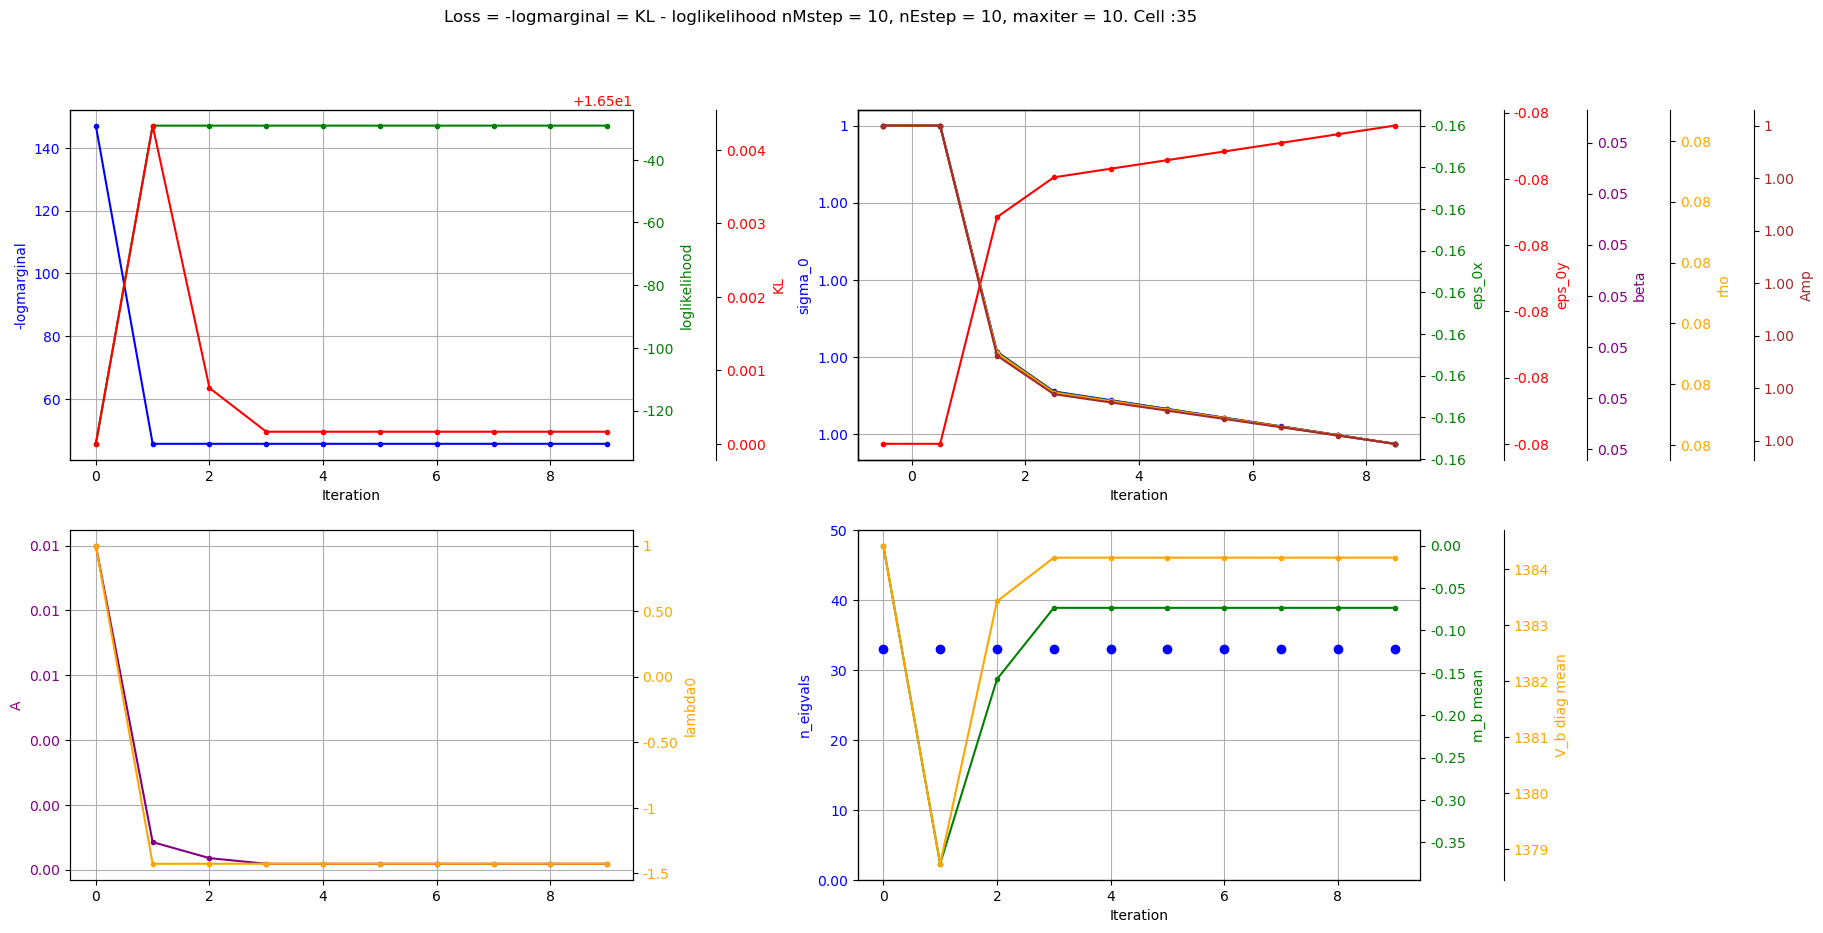

In [5]:
torch.set_grad_enabled(False)
fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

# Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
start_model = fit_model

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

# Save the model
# utils.save_model(start_model, f'models/starting_models_active_learning/cell:{cellid}_nstart:{ntrain_start}', additional_description='Starting model for active learning')

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model )
# spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **start_model )

utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))


### Save or load model

In [6]:
# Save the model
# utils.save_model(fit_model, f'models/bugs/cell:{cellid}', additional_description='Model started with 50 ntilde=ntrain, randomly picked images until nan in r2. Saved last model (after fit ). It gives Nan')
# start_model = utils.load_model(f'models/starting_models_active_learning/cell:8_nstart:20')

### Evaluate the utility of each remaining image

In [6]:
in_use_idx    = start_model['fit_parameters']['in_use_idx']
xtilde_idx    = start_model['fit_parameters']['xtilde_idx']

remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

X_remaining = X[remaining_idx]
R_remaining = R[remaining_idx]

xtilde      = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

xstar = X_remaining

kernfun       = start_model['fit_parameters']['kernfun']
mask          = start_model['mask']
C             = start_model['C']
B             = start_model['B']
K_tilde_b     = start_model['K_tilde_b']
K_tilde_inv_b = start_model['K_tilde_inv_b']
K_b           = start_model['K_b']
Kvec          = start_model['Kvec']
m_b           = start_model['m_b']
V_b           = start_model['V_b']    
f_params_fit  = start_model['f_params']
A             = torch.exp(f_params_fit['logA'])
lambda0       = torch.exp(f_params_fit['loglambda0']) if 'loglambda0' in f_params_fit else f_params_fit['lambda0']

start_time = time.time()

# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  

# These are the moments of the log firing rate. Not the log of the moments of the firing rate log<f> = A*lambda_m_t + A**2 * lambda_var_t + lambda0. look at (37) notes
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t

# Estimate the utility and cap the maximum r ( used in a summation to infinity )
r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
u2d = utils.nd_utility(logf_var, logf_mean, r_masked )
print(f'\nElapsed time for lambda moments and utility : {time.time()-start_time:.2f} seconds')  



Elapsed time for lambda moments and utility : 0.02 seconds


### Find the index(es) for the most useful image 
Check the correspondence between the index: ```i_best``` of the ```xstar = X_remaining``` images with the one: ```x_idx_best```  for the complete dataset ```X```

In [4]:
915/60

15.25

In [7]:
i_best     = u2d.argmax()           # Index of the best image in the utility vector
x_idx_best = remaining_idx[i_best]  # Index of the best image in the dataset indices
print(f'Utility: {u2d[i_best].item():<8.4f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')


# Using the indexes of the utility
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var[i_best], logf_mean[i_best], r_masked)} and f_mean :{torch.exp(logf_mean[i_best]).item():8.4f}')


# Using the indixes of the dataset X
# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 
lambda_m_t, lambda_var_t = utils.lambda_moments( X[x_idx_best,mask][None,:], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var, logf_mean, r_masked)} and f_mean :{torch.exp(logf_mean).item():8.4f}')

Utility: 0.0001   |  Best image ID: 1875  | Best image index: 3072
 this has utility tensor([5.8246e-05], device='cuda:0') and f_mean :  0.2401
 this has utility tensor([5.8246e-05], device='cuda:0') and f_mean :  0.2401


### Active learning loop
Update the indexes tensors and fit the new model in a loop 

After fitting the model with the dataset incremented by one image, reevaluate the utility, find the best mage index and loop.


In [8]:
torch.set_grad_enabled(False)

active_model = copy.deepcopy(start_model)

loglk_test_1000_active = torch.zeros(n_add_images, dtype=torch.float16)
threads = []

for j in range(n_add_images):
    print(f'=========== New image number {j} ====================')

    # region __________ Retrieve the values from the last model fit __________
    in_use_idx    = active_model['fit_parameters']['in_use_idx']
    xtilde_idx    = active_model['fit_parameters']['xtilde_idx']

    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]

    xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

    xstar  = X_remaining

    kernfun       = active_model['fit_parameters']['kernfun']
    if kernfun == 'acosker': kernfun = utils.acosker
    n_px_side     = active_model['fit_parameters']['n_px_side']
    EIGVAL_TOL    = active_model['fit_parameters']['eigval_tol']

    final_kernel  = active_model['final_kernel']
    
    mask          = active_model['mask']
    C             = active_model['C']
    B             = active_model['B']
    K_tilde_b     = active_model['K_tilde_b']
    K_tilde_inv_b = active_model['K_tilde_inv_b']
    K_b           = active_model['K_b']
    Kvec          = active_model['Kvec']
    m_b           = active_model['m_b']
    V_b           = active_model['V_b']    
    f_params      = active_model['f_params']
    theta         = active_model['hyperparams_tuple'][0]
    A             = torch.exp(f_params['logA'])
    lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']
    
    theta_lower_lims  = active_model['hyperparams_tuple'][1]
    theta_higher_lims = active_model['hyperparams_tuple'][2]

    # endregion

    # region __________ Calculate the loglikelihood on the 1000 Test set __________

    def calculate_loglikelihood_thread(X_test_1000, R_test_1000, xtilde, B, K_tilde_b, K_tilde_inv_b, C, m_b, V_b, theta, f_params, mask, kernfun, loglk_test_1000_active, index):
        start_time_thread = time.time()
        Kvec_test = kernfun(theta, X_test_1000[:,mask], x2=None, C=C, dC=None, diag=True)
        K_test    = kernfun(theta, X_test_1000[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
        K_test_b  = K_test @ B 

        lambda_m_t, lambda_var_t = utils.lambda_moments(X_test_1000[:,mask], K_tilde_b, K_test_b@K_tilde_inv_b, Kvec_test, K_test_b, C, m_b, V_b, theta)

        f_mean = utils.mean_f_given_lambda_moments(f_params, lambda_m_t, lambda_var_t)

        loglk_test_1000_active[index] = utils.compute_loglikelihood(R_test_1000, f_mean, lambda_m_t, lambda_var_t, f_params)[0] 

        print(f" loglk_test_1000_active[{index}]: {loglk_test_1000_active[index]} inside threading") 

    thread = threading.Thread(target=calculate_loglikelihood_thread, args=(X_test_1000, R_test_1000, xtilde, B, K_tilde_b, K_tilde_inv_b, C, 
                                                                            m_b, V_b, theta, f_params, mask, kernfun, loglk_test_1000_active, j))
    threads.append(thread)
    thread.start()
    # endregion    

    # region __________ Calculate the utility of each remaining image __________
    # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
    Kvec_star = kernfun(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
    K_star    = kernfun(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
    K_star_b  = K_star @ B 

    lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta)  

    logf_mean = A*lambda_m_t + lambda0
    logf_var  = A**2 * lambda_var_t

    # Estimate the utility and cap the maximum r ( used in a summation to infinity )
    r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
    if torch.any(logf_var < 0):
        print('logf_var is negative, choosing i_best = 0')
        u2d = torch.zeros(xstar.shape[0])
        i_best = 0
    else:
        u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )
        i_best   = u2d.argmax()                                        # Index of the best image in the utility vector

    # i_best = torch.randint(0, u2d.shape[0], (1,)).item(
    x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices
    print(f'x_idx_best: {x_idx_best}')
    print(f'Utility: {u2d[i_best].item():<8.6f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')

    if x_idx_best in in_use_idx :
        raise ValueError('The best image is already in use or in the test set')
    if x_idx_best in test_1000_idx:
        raise ValueError('The best image is in the test set')
    
    # endregion

    # region __________ Update indices and Kernels __________ 
    prev_active_model = copy.deepcopy(active_model)
    # Always sort the indices. We also update the remaining only to have consistency, not cause they are used here
    in_use_idx    = torch.cat( (in_use_idx, x_idx_best[None]))
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

    X_in_use    = X[in_use_idx]
    R_in_use    = R[in_use_idx] 
    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]
    # # The added images are used as inducing points as long as the number of inducing points is less than 200
    # # if in_use_idx.shape[0] < 200:
    xtilde_idx     = in_use_idx
    ntilde         = xtilde_idx.shape[0]
    nt             = X_in_use.shape[0]
    # We add it as the last row. This is not ensured if we use X[xtilde_idx] instead of xtilde
    xtilde_updated = X[xtilde_idx]
    # xtilde_updated = torch.cat((xtilde, X[x_idx_best][None,:]), axis=0) 

    active_model['xtilde']                       = xtilde_updated
    active_model['fit_parameters']['ntilde']     = ntilde
    active_model['fit_parameters']['in_use_idx'] = in_use_idx
    active_model['fit_parameters']['xtilde_idx'] = xtilde_idx

    # __________ Update variational parameters
    # To update the variational parameters to the new dimensionality we need to pass through the original space. 
    # V and m will be projected onto the right eigenspace in varGP using the last used B.
    V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
    V = 0.5*(V + V.T)    # Ensure symmetry
    m = B @ m_b          # shape (ntilde-1,)

    V_new = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
    V_new[:ntilde-1, :ntilde-1] = V       

    active_model['V'] = V_new 
    active_model['m'] = torch.cat( (m, m.mean()[None]))

    # __________ Update kernel matrices by only computing their latest column
    init_kernel = {}
    C                     = final_kernel['C']
    mask                  = final_kernel['mask']
    K_tilde_reduced       = final_kernel['K_tilde']            # We call it reduced because its still the Ktilde used in the last iteration
    K_reduced             = final_kernel['K']           

    #100 computattions of K_tilde this way take ~0.03s.
    K_tilde_column  = kernfun(theta, xtilde_updated[:,mask], xtilde_updated[-1,mask][None], C=C, dC=None, diag=False) 
    K_tilde         = torch.cat((K_tilde_reduced, K_tilde_column[:-1]), axis=1)
    K_tilde         = torch.cat((K_tilde, K_tilde_column.T), axis=0)  

    if ntilde==nt: K = K_tilde
    else: raise NotImplementedError('Fast calculation of K not implemented for ntilde != ntrain')

    Kvec            = kernfun(theta, X_in_use[:,mask],x2=None, C=C, dC=None, diag=True)   
    # endregion

    # region __________ Project the matrices in the eigenspace of the largest eigenvectors __________
    eigvals, eigvecs = torch.linalg.eigh(K_tilde, UPLO='L')                                # calculates the eigenvals for an assumed symmetric matrix, eigenvalues  are returned in ascending order. Uplo=L uses the lower triangular part of the matrix. Eigenvectors are columns
    ikeep            = eigvals > max(eigvals.max() * EIGVAL_TOL, EIGVAL_TOL)                          # Keep only the largest eigenvectors
    B                = eigvecs[:, ikeep]                                     
    # make K_tilde_b and K_b a projection of K_tilde and K into the eigenspace of the largest eigenvectors
    K_tilde_b        = torch.diag(eigvals[ikeep])                    
    K_b              = K @ B                                         
    
    K_tilde_inv_b = torch.diag_embed(1/eigvals[ikeep])        
    KKtilde_inv_b = B if ntilde==nt else K_b @ K_tilde_inv_b
    # endregion

    # region __________ Save the updated kernel to a dict to feed to the model __________
    init_kernel['C']                 = C
    init_kernel['mask']              = mask
    init_kernel['K_tilde']           = K_tilde
    init_kernel['K']                 = K
    init_kernel['Kvec']              = Kvec
    init_kernel['B']                 = B
    init_kernel['K_tilde_b']         = K_tilde_b
    init_kernel['K_b']               = K_b
    init_kernel['K_tilde_inv_b']     = K_tilde_inv_b
    init_kernel['KKtilde_inv_b']     = KKtilde_inv_b

    print(f'Number of inducing points: {ntilde}')
    print(f'Number of images used:     {in_use_idx.shape[0]}')

    active_model['init_kernel']      = init_kernel        # We update the model after copy because deepcopy doesnt work if 'init_kernel' is a key
    # endregion
    
    # region __________ Fit new model __________
    active_model, err_dict = utils.varGP(X_in_use, R_in_use, **active_model)

    if err_dict['is_error']:
        print('Error in the fit')
        raise err_dict['error']

    # Wait for the thread to finish
    threads[j].join()

    # endregion
    
    # region __________ Test the model r squared and log likelihood on the two test set __________
    
    # if torch.any(torch.isnan(r2)):
    #     print('r2 is nan')
    #     raise ValueError('r2 is nan')

    # r2_vec.append(r2)
    # loss_vec.append(-active_model['values_track']['loss_track']['logmarginal'][-1])

    # spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **active_model )
    # utils.plot_loss_and_theta_notebook(active_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))

    # endregion

# Save likelihood tensor
with open(f'data/loglk_test_1000_active_cell_{cellid}_nstart_{ntrain_start}_to_{n_add_images+ntrain_start}_3iter.pkl', 'wb') as file:
    pickle.dump(loglk_test_1000_active, file)
       

=========== New image number 0 ====================
 loglk_test_1000_active[0]: -525.5 inside threading
x_idx_best: 3072
Utility: 0.000058 |  Best image ID: 1875  | Best image index: 3072
Number of inducing points: 51
Number of images used:     51
Initial Loss: 214.5238
Loss iter 1: 43.3630
Loss iter 2: 43.3630
Loss iter 3: 43.3630
Loss iter 4: 43.3630
Loss iter 5: 43.3630
Loss iter 6: 43.3630
Loss iter 7: 43.3630
Loss iter 8: 43.3630
Loss iter 9: 43.3630

Time spent for E-steps:       0.126s,
Time spent for f params:      0.085s
Time spent for m update:      0.041s
Time spent for M-steps:       0.120s
Time spent for All-steps:     0.246s
Time spent computing Kernels: 0.019s
Time spent computing Loss:    0.004s

Time total after init:        0.271s
Time total before init:       0.272s
Final Loss: 43.3630
=========== New image number 1 ====================
 loglk_test_1000_active[1]: -524.5 inside threading
x_idx_best: 787
Utility: 0.000003 |  Best image ID: 1756  | Best image index: 78

### Random learning loop
We now fit the model by randomly picking the next image. 

We loop it 10 times to get a good statistics


Following 2 cells are for the ntilde=0.5 ntrain bug

In [10]:
# random_model = copy.deepcopy(random_model_copy)
# prev_random_model_copy = copy.deepcopy(prev_random_model)
# random_model = copy.deepcopy(prev_random_model_copy)

In [11]:
# utils.save_model(random_model, f'models/bugs/cell:{cellid}_negative_variance_1080ntilde', additional_description='Bugged model that gives negative variance in the utility for 1080 ntilde, which correspondes to half the dataset')
# random_model = utils.load_model(f'models/bugs/cell:{cellid}_negative_variance_1080ntilde')

In [ ]:
torch.set_grad_enabled(False)

loglk_test_1000_random = torch.zeros((n_random_starts,n_add_images), dtype=torch.float16)
threads = []

# for s in range(n_random_starts):
for s in range(n_random_starts):

    in_use_idx    = start_model['fit_parameters']['in_use_idx']
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]
    
    random_model = copy.deepcopy(start_model)

    for j in range(remaining_idx.shape[0]):
    
        print(f'=========== Trial {s} - New image number {j} ====================')

        # region __________ Retreive the values from the last model fit __________
        in_use_idx    = random_model['fit_parameters']['in_use_idx']
        xtilde_idx    = random_model['fit_parameters']['xtilde_idx']

        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

        xstar  = X_remaining

        kernfun       = random_model['fit_parameters']['kernfun']
        if kernfun == 'acosker': kernfun = utils.acosker
        n_px_side     = random_model['fit_parameters']['n_px_side']
        EIGVAL_TOL    = random_model['fit_parameters']['eigval_tol']

        final_kernel  = random_model['final_kernel']
        
        mask          = random_model['mask']
        C             = random_model['C']
        B             = random_model['B']
        K_tilde_b     = random_model['K_tilde_b']
        K_tilde_inv_b = random_model['K_tilde_inv_b']
        K_b           = random_model['K_b']
        Kvec          = random_model['Kvec']
        m_b           = random_model['m_b']
        V_b           = random_model['V_b']    
        f_params      = random_model['f_params']
        theta         = random_model['hyperparams_tuple'][0]
        A             = torch.exp(f_params['logA'])
        lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']
        
        theta_lower_lims  = random_model['hyperparams_tuple'][1]
        theta_higher_lims = random_model['hyperparams_tuple'][2]

        # endregion

        # region __________ Calculate the loglikelihood on the 1000 Test set __________

        def calculate_loglikelihood_thread():
                Kvec_test = kernfun(theta, X_test_1000[:,mask], x2=None, C=C, dC=None, diag=True)
                K_test    = kernfun(theta, X_test_1000[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
                K_test_b  = K_test @ B 

                lambda_m_t, lambda_var_t = utils.lambda_moments(X_test_1000[:,mask], K_tilde_b, K_test_b@K_tilde_inv_b, Kvec_test, 
                                                                K_test_b, C, m_b, V_b, theta)

                f_mean = utils.mean_f_given_lambda_moments(f_params, lambda_m_t, lambda_var_t)

                loglk_test_1000_random[s,j] = utils.compute_loglikelihood(R_test_1000, f_mean, lambda_m_t, lambda_var_t, f_params)[0] 


        thread = threading.Thread(target=calculate_loglikelihood_thread,)
        threads.append(thread)
        thread.start()

        # endregion    

        # region __________ Extract random new index ( no utility ) __________

        i_best = torch.randint(0, remaining_idx.shape[0], (1,)).item()
        x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices

        if x_idx_best in in_use_idx :          raise ValueError('The best image is already in use or in the test set')
        if x_idx_best in test_1000_idx:        raise ValueError('The best image is in the test set')
        
        # endregion

        # region __________ Update indices and Kernels __________ 
        prev_random_model = copy.deepcopy(random_model) # Save the previous model before updating it
        # Always sort the indices. We also update the remaining only to have consistency, not cause they are used here
        in_use_idx    = torch.cat( (in_use_idx, x_idx_best[None]))
        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

        X_in_use    = X[in_use_idx]
        R_in_use    = R[in_use_idx] 
        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]
        # # The added images are used as inducing points as long as the number of inducing points is less than 200
        # # if in_use_idx.shape[0] < 200:
        xtilde_idx     = in_use_idx
        ntilde         = xtilde_idx.shape[0]
        nt             = X_in_use.shape[0]
        # We add it as the last row. This is not ensured if we use X[xtilde_idx] instead of xtilde
        xtilde_updated = X[xtilde_idx]
        # xtilde_updated = torch.cat((xtilde, X[x_idx_best][None,:]), axis=0) 

        random_model['xtilde']                       = xtilde_updated
        random_model['fit_parameters']['ntilde']     = ntilde
        random_model['fit_parameters']['in_use_idx'] = in_use_idx
        random_model['fit_parameters']['xtilde_idx'] = xtilde_idx

        # __________ Update variational parameters
        # To update the variational parameters to the new dimensionality we need to pass through the original space. 
        # V and m will be projected onto the right eigenspace in varGP using the last used B.
        V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
        V = 0.5*(V + V.T)    # Ensure symmetry
        m = B @ m_b          # shape (ntilde-1,)

        V_new = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
        V_new[:ntilde-1, :ntilde-1] = V       

        random_model['V'] = V_new 
        random_model['m'] = torch.cat( (m, m.mean()[None]))

        # __________ Update kernel matrices by only computing their latest column
        init_kernel = {}
        C                     = final_kernel['C']
        mask                  = final_kernel['mask']
        K_tilde_reduced       = final_kernel['K_tilde']            # We call it reduced because its still the Ktilde used in the last iteration
        K_reduced             = final_kernel['K']           

        #100 computattions of K_tilde this way take ~0.03s.
        K_tilde_column  = kernfun(theta, xtilde_updated[:,mask], xtilde_updated[-1,mask][None], C=C, dC=None, diag=False) 
        K_tilde         = torch.cat((K_tilde_reduced, K_tilde_column[:-1]), axis=1)
        K_tilde         = torch.cat((K_tilde, K_tilde_column.T), axis=0)  

        if ntilde==nt: K = K_tilde
        else: raise NotImplementedError('Fast calculation of K not implemented for ntilde != ntrain')

        Kvec            = kernfun(theta, X_in_use[:,mask],x2=None, C=C, dC=None, diag=True)   
        # endregion

        # region __________ Project the matrices in the eigenspace of the largest eigenvectors __________
        eigvals, eigvecs = torch.linalg.eigh(K_tilde, UPLO='L')                                # calculates the eigenvals for an assumed symmetric matrix, eigenvalues  are returned in ascending order. Uplo=L uses the lower triangular part of the matrix. Eigenvectors are columns
        ikeep            = eigvals > max(eigvals.max() * EIGVAL_TOL, EIGVAL_TOL)                          # Keep only the largest eigenvectors
        B                = eigvecs[:, ikeep]                                     
        # make K_tilde_b and K_b a projection of K_tilde and K into the eigenspace of the largest eigenvectors
        K_tilde_b        = torch.diag(eigvals[ikeep])                    
        K_b              = K @ B                                         
        
        K_tilde_inv_b = torch.diag_embed(1/eigvals[ikeep])        
        KKtilde_inv_b = B if ntilde==nt else K_b @ K_tilde_inv_b
        # endregion

        # region __________ Save the updated kernel to a dict to feed to the model __________
        init_kernel['C']                 = C
        init_kernel['mask']              = mask
        init_kernel['K_tilde']           = K_tilde
        init_kernel['K']                 = K
        init_kernel['Kvec']              = Kvec
        init_kernel['B']                 = B
        init_kernel['K_tilde_b']         = K_tilde_b
        init_kernel['K_b']               = K_b
        init_kernel['K_tilde_inv_b']     = K_tilde_inv_b
        init_kernel['KKtilde_inv_b']     = KKtilde_inv_b

        print(f'Number of inducing points: {ntilde}')
        print(f'Number of images used:     {in_use_idx.shape[0]}')

        random_model['init_kernel']      = init_kernel        # We update the model after copy because deepcopy doesnt work if 'init_kernel' is a key
        # endregion
        
        # region __________ Fit new model __________
        random_model, err_dict = utils.varGP(X_in_use, R_in_use, **random_model)

        if err_dict['is_error']:
            print('Error in the fit')
            raise err_dict['error']

        # Wait for the thread to finish
        threads[j].join()

        # endregion
        
        # region __________ Test the model r squared and log likelihood on the two test set __________
        
        # if torch.any(torch.isnan(r2)):
        #     print('r2 is nan')
        #     raise ValueError('r2 is nan')

        # r2_vec.append(r2)
        # loss_vec.append(-random_model['values_track']['loss_track']['logmarginal'][-1])

        # spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **random_model )
        # utils.plot_loss_and_theta_notebook(random_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))

        # Save updated likelihood tensor ( overwrite )
        with open(f'data/2loglk_test_1000_random_cell_{cellid}_nstart_{ntrain_start}_to_{n_add_images+ntrain_start}_3iter.pkl', 'wb') as file:
            pickle.dump(loglk_test_1000_random, file)          
        # endregion



### Benchmark model: 
#### We tran the model with ntilde=ntrain=MAX and evaluate the likelihood of the same test set
The differenche between these two likelihoods is the mesure of how good our active model is.
We will then train a model randomly and compare that too

updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to -0.1588
updated eps_0y to -0.0832
updated -2log2beta to 4.8069
updated -log2rho2 to 4.3069
Initial Loss: 5474.6758
Loss iter 1: 1553.1843
Loss iter 2: 1504.0391

Time spent for E-steps:       1.760s,
Time spent for f params:      1.747s
Time spent for m update:      0.013s
Time spent for M-steps:       1.306s
Time spent for All-steps:     3.066s
Time spent computing Kernels: 0.105s
Time spent computing Loss:    0.001s

Time total after init:        3.174s
Time total before init:       3.293s
Final Loss: 1504.0391


 Pietro's model: R2 = 0.49 ± 0.01 Cell: 4 maxiter = 3, nEstep = 10, nMstep = 10 



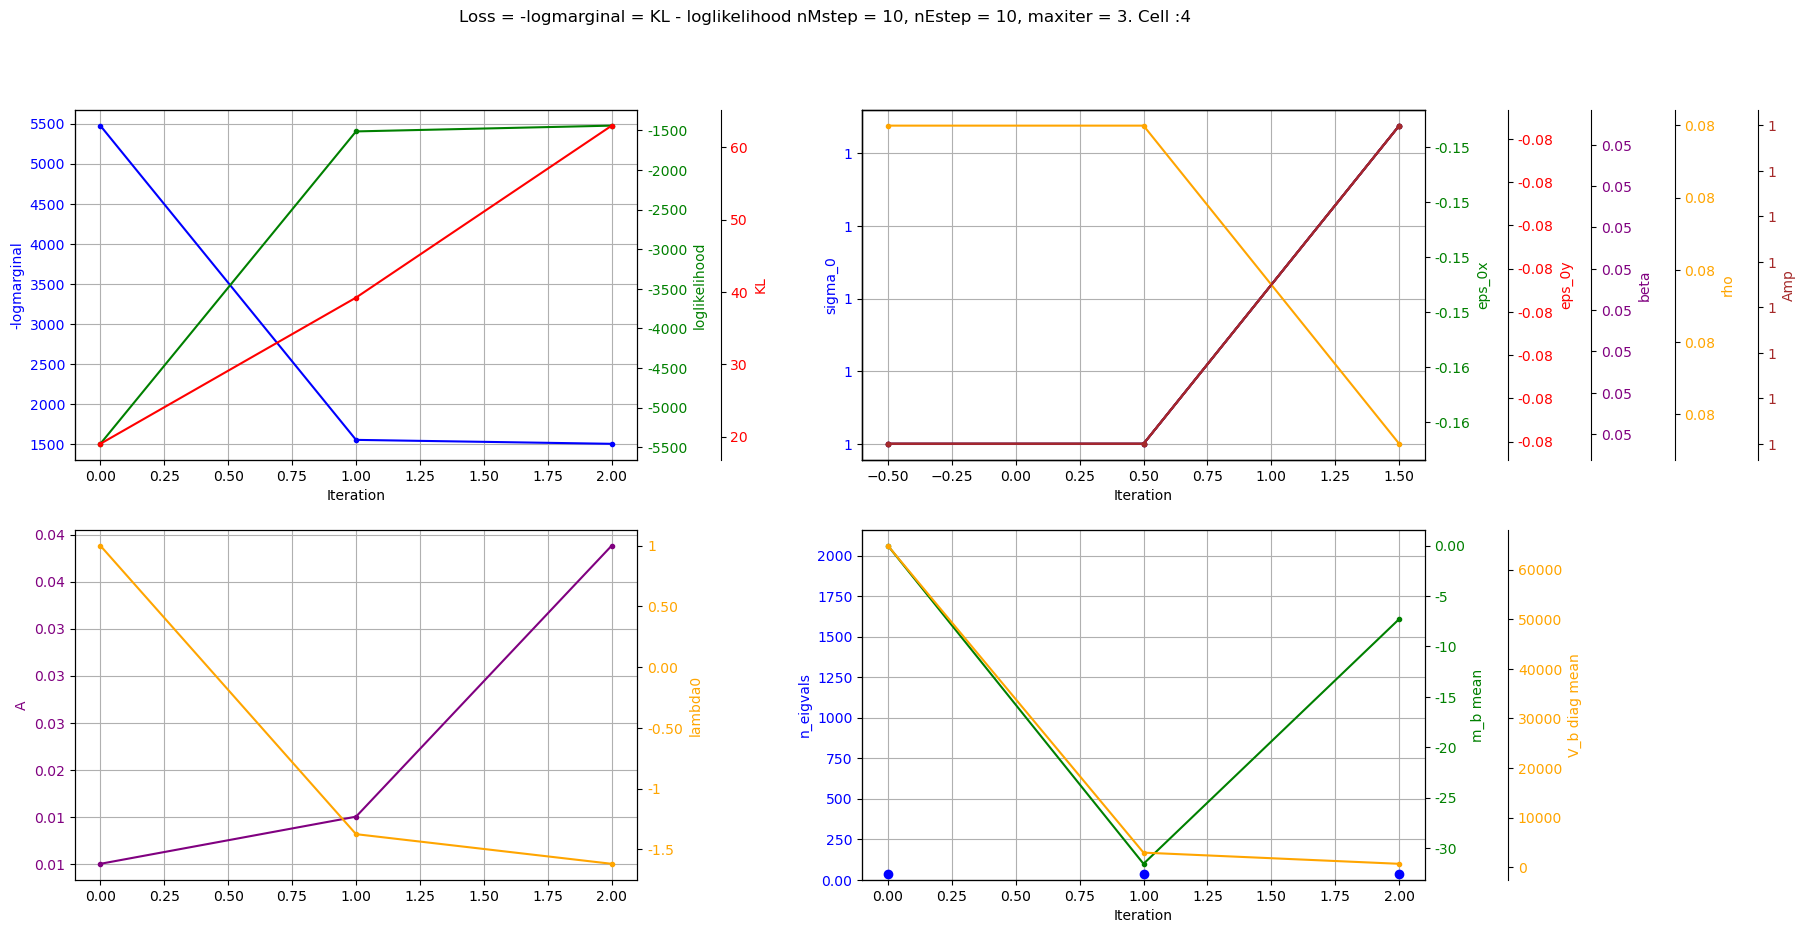

Time taken for loglikelihood calculation: 0.0059 seconds


In [6]:
# region __________ Generate the complete training set __________
kernfun      = 'acosker' 
ntrain_start_max = X.shape[0] - n_test_lk         # Number of training points is the maximum possible without the test set
ntilde       = ntrain_start_max 

all_idx  = torch.arange(0, X.shape[0])                    
torch.manual_seed(0)
torch.cuda.manual_seed(0)
all_idx_perm  = torch.randperm(all_idx.shape[0])  # Same Random permutation of the indices as above

test_1000_idx = all_idx_perm[-n_test_lk:]                                
all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] 
rndm_idx      = all_idx_perm[:]                   # These will be the indices of the initial training, we take them all this time

start_idx     = rndm_idx
in_use_idx    = start_idx
xtilde_idx    = in_use_idx
remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

# Set the starting set
xtilde_start  = X[xtilde_idx,:]                           
X_in_use      = X[in_use_idx,:]
X_remaining   = X[remaining_idx,:]
X_test_1000   = X[test_1000_idx,:]

R_remaining   = R[remaining_idx]
R_in_use      = R[in_use_idx]
R_test_1000   = R[test_1000_idx]

# endregion

# region __________ Set hyperparams __________
logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 
sigma_0    = torch.tensor(1.0)
Amp        = torch.tensor(1.0) 
# eps_0x     = torch.tensor(0.0001)
# eps_0y     = torch.tensor(0.0001)
eps_0x     = torch.tensor(-0.15878)
eps_0y     = torch.tensor(-0.08321)

theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

for key, value in theta.items():
    theta[key] = value.requires_grad_()

hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=False, **theta)

A        = torch.tensor(0.01)
logA     = torch.log(A)
lambda0  = torch.tensor(1.)
f_params = {'logA': logA, 'lambda0':lambda0}
f_params['logA'] = f_params['logA'].requires_grad_() # The optimal lambda0 is given with a fixed A.

fit_parameters = {'ntilde':      ntilde,
                  'maxiter':     maxiter,
                  'nMstep':      nMstep,
                  'nEstep':      nEstep,
                  'nFparamstep': nFparamstep,
                  'kernfun':     kernfun,
                  'cellid':      cellid,
                  'n_px_side':   n_px_side,
                  'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                  'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                  'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

init_model_max = {
        'fit_parameters':    fit_parameters,
        'xtilde':            xtilde_start,
        'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
        'f_params':          f_params,
    }

# endregion

# region __________ Fit, save and plot the model __________

# init_model_max['fit_parameters']['nMstep'] = 10
# init_model_max['fit_parameters']['maxiter'] = 20

fit_model_max, err_dict = utils.varGP(X_in_use, R_in_use, **init_model_max)

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

# Save the model
# utils.save_model(start_model, f'models/cell:{cellid}_nstart:{ntrain_start_max}_Testseed_0', additional_description='Max model with test seed 0  and no M step')

# Or load the model
# fit_model_max = utils.load_model(f'models/cell:14_nstart:2160_Testseed_0')

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model_max )
utils.plot_loss_and_theta_notebook(fit_model_max, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))

# endregion

# region __________ Calculate the loglikelihood on the 1000 Test set __________

in_use_idx    = fit_model_max['fit_parameters']['in_use_idx']
xtilde_idx    = fit_model_max['fit_parameters']['xtilde_idx']

xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

mask          = fit_model_max['mask']
C             = fit_model_max['C']
K_tilde_b     = fit_model_max['K_tilde_b']
K_tilde_inv_b = fit_model_max['K_tilde_inv_b']
B             = fit_model_max['B']

m_b           = fit_model_max['m_b']
V_b           = fit_model_max['V_b']    
f_params      = fit_model_max['f_params']
theta         = fit_model_max['hyperparams_tuple'][0]
A             = torch.exp(f_params['logA'])
lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']

theta_lower_lims  = fit_model_max['hyperparams_tuple'][1]
theta_higher_lims = fit_model_max['hyperparams_tuple'][2]

start_time = time.time()
Kvec_test = utils.acosker(theta, X_test_1000[:,mask], x2=None, C=C, dC=None, diag=True)
K_test    = utils.acosker(theta, X_test_1000[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
K_test_b  = K_test @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments(X_test_1000[:,mask], K_tilde_b, K_test_b@K_tilde_inv_b, Kvec_test, K_test_b, C, m_b, V_b, theta)

f_mean = utils.mean_f_given_lambda_moments(f_params, lambda_m_t, lambda_var_t)

loglk_test_1000_max = utils.compute_loglikelihood(R_test_1000, f_mean, lambda_m_t, lambda_var_t, f_params)[0] 

print(f"Time taken for loglikelihood calculation: {time.time()-start_time:.4f} seconds")

# endregion    

# Save likelihood tensor
with open(f'data/loglk_test_1000_max_cell_{cellid}_3iter.pkl', 'wb') as file:
    pickle.dump(loglk_test_1000_max, file)

#### Compare max model with active model run until the end

We are using the max model likelihood as indicator of best performance, are we sure that we arrive at the same value? 



### Compare models

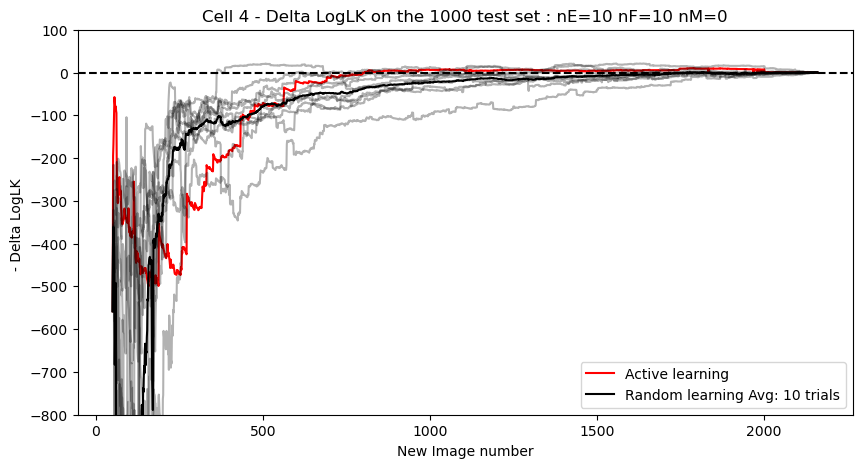

In [ ]:
# Old plot with noMstep

# Upload a active loop likelihood 
# with open('data/loglk_test_1000_active_cell_8_nstart_50_to_1000.pkl', 'rb') as f:
with open('data/loglk_test_1000_active_cell_4_nstart_50_to_2160_noM.pkl', 'rb') as f:
    loglk_test_1000_active = pickle.load(f)

# Upload the random loop likelihood
# with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_1000.pkl', 'rb') as file:
with open(f'data/loglk_test_1000_random_cell_4_nstart_50_to_2160_noM.pkl', 'rb') as file:
    loglk_test_1000_random = pickle.load(file)

# Upload the max model likelihood
with open('data/loglk_test_1000_max_cell_4_noM_20iterations.pkl', 'rb') as f:
    loglk_test_1000_max = pickle.load(f)

plt.figure(figsize=(10,5))
xrange = np.arange(50, 50+loglk_test_1000_active.shape[0])

plt.plot(xrange, loglk_test_1000_active.cpu().numpy()-loglk_test_1000_max.cpu().numpy(), label='Active learning', color='red', )  


for i in range(loglk_test_1000_random.shape[0]):
    plt.plot(xrange, loglk_test_1000_random[i,:].cpu().numpy()-loglk_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     


# Plot the loglk random averaged over rows
plt.plot(xrange, loglk_test_1000_random.mean(0).cpu().numpy()-loglk_test_1000_max.cpu().numpy(), label=f'Random learning Avg: {n_random_starts} trials', color='black' )

plt.ylim(-800,100)
# plt.xlim(1900,2160)
plt.ylabel('- Delta LogLK ')
plt.xlabel('New Image number')
plt.title(f'Cell {cellid} - Delta LogLK on the 1000 test set : nE={nEstep} nF={nFparamstep} nM={nMstep}')
plt.axhline(0, color='black', linestyle='--')

plt.legend()

# Save the image
# plt.savefig(f'figures/Cell_{cellid}_DeltaLogLK_nstart_{ntrain_start}_to_{ntrain_start+n_add_images}_nE_{nEstep}_nF_{nFparamstep}_nM_{nMstep}_noM.png')

# BUG IN NO MSTEP 2000 NEW IMAGES FOR CELL 14